In [166]:

from datetime import datetime as dt
import git
import numpy as np
import pandas as pd
import warnings
import math 
import plotly.express as px
import plotly.graph_objects as go
from dash import MATCH, Dash, Input, Output, callback, dcc, html
from vehicle_stream_pipeline import utils

warnings.filterwarnings("ignore")


In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
repo = git.Repo(".", search_parent_directories=True).git.rev_parse("--show-toplevel")

# fetch data (here we can automate it)
df_stops = pd.read_excel(
    f"{repo}/data/other/MoDstops+Preismodell.xlsx", sheet_name="MoDstops"
)

df_edges = pd.read_excel(
    f"{repo}/data/other/MoDstops+Preismodell.xlsx", sheet_name="Liste 2022"
)

df_edges.rename(columns={"Start #": "start_id", "Ende #": "end_id"}, inplace=True)

# rides_df = pd.read_csv(f"{repo}/data/cleaning/data_cleaned.csv")
rides_df = pd.read_excel(f"{repo}/data/cleaning/data_cleaned_1808.xlsx")
rides_df = rides_df[(rides_df["state"] == "completed")]
rides_df["scheduled_to"] = pd.to_datetime(rides_df["scheduled_to"])

sim_df_small = pd.read_csv(f"{repo}/data/sim_rides_1808_9.csv")
sim_df_large = pd.read_csv(f"{repo}/data/sim_rides_600k.csv")




In [169]:
rides_df.columns

Index(['Unnamed: 0', 'id', 'user_id', 'distance', 'number_of_passenger',
       'price_operations', 'price_offer', 'price_payed', 'free_ride',
       'payment_type', 'pickup_address', 'dropoff_address', 'state',
       'created_from_offer', 'created_at', 'scheduled_to', 'dispatched_at',
       'pickup_arrival_time', 'arriving_push', 'vehicle_arrived_at',
       'earliest_pickup_expectation', 'pickup_first_eta', 'pickup_eta',
       'pickup_at', 'dropoff_first_eta', 'dropoff_eta', 'dropoff_at',
       'updated_at', 'arrival_deviation', 'waiting_time', 'boarding_time',
       'ride_time', 'trip_time', 'shortest_ridetime', 'delay',
       'longer_route_factor', 'arrival_indicator', 'rating',
       'rating_puenktlichkeit', 'rating_sauberkeit', 'rating_fahrer',
       'rating_find_modstop', 'rating_other_comments', 'cancellation_reason',
       'cancellation_comment', 'bahn_card_number', 'year_card_type',
       'year_card_number', 'canceled_at', 'rating_question_one',
       'rating_quest

In [170]:
# deviate attributes for day distribution
dist_df = rides_df.copy()

dist_df.columns
dist_df["dataset"] = "Original Rides"
dist_df["route"] = dist_df["pickup_address"].astype(str) + dist_df["dropoff_address"].astype(str) 
dist_df["pickup_at"] = pd.to_datetime(dist_df["pickup_at"], errors="coerce")
hour = dist_df["pickup_at"].dt.hour
month = dist_df["pickup_at"].dt.month
day_of_month = dist_df["pickup_at"].dt.day
year = dist_df["pickup_at"].dt.year
week = dist_df["pickup_at"].dt.isocalendar().week
day_of_week = dist_df["pickup_at"].dt.dayofweek
dist_df.insert(loc=1, column="week", value=week)
dist_df.insert(loc=2, column="month", value=month)
dist_df.insert(loc=3, column="day_of_month", value=day_of_month)
dist_df.insert(loc=4, column="hour", value=hour)
dist_df.insert(loc=5, column="year", value=year)
dist_df.insert(loc=6, column="day_of_week", value=day_of_week)
dist_df["month_year"] =  dist_df['pickup_at'].dt.strftime('%Y%m')


In [171]:
# deviate attributes for day distribution
dist_df_sim_s = sim_df_small.copy()

dist_df_sim_s.columns
dist_df_sim_s["dataset"] = "Simulated Rides small"
dist_df_sim_s["route"] = dist_df_sim_s["pickup_address"].astype(str) + dist_df_sim_s["dropoff_address"].astype(str) 
dist_df_sim_s["pickup_at"] = pd.to_datetime(dist_df_sim_s["pickup_at"], errors="coerce")
hour = dist_df_sim_s["pickup_at"].dt.hour
month = dist_df_sim_s["pickup_at"].dt.month
day_of_month = dist_df_sim_s["pickup_at"].dt.day
year = dist_df_sim_s["pickup_at"].dt.year
week = dist_df_sim_s["pickup_at"].dt.isocalendar().week
day_of_week = dist_df_sim_s["pickup_at"].dt.dayofweek
dist_df_sim_s.insert(loc=1, column="week", value=week)
dist_df_sim_s.insert(loc=2, column="month", value=month)
dist_df_sim_s.insert(loc=3, column="day_of_month", value=day_of_month)
dist_df_sim_s.insert(loc=4, column="hour", value=hour)
dist_df_sim_s.insert(loc=5, column="year", value=year)
dist_df_sim_s.insert(loc=6, column="day_of_week", value=day_of_week)
dist_df_sim_s["month_year"] =  dist_df_sim_s['pickup_at'].dt.strftime('%Y%m')


In [172]:
# deviate attributes for day distribution
dist_df_sim_l = sim_df_large.copy()

dist_df_sim_l.columns
dist_df_sim_l["dataset"] = "Simulated Rides large"
dist_df_sim_l["route"] = dist_df_sim_l["pickup_address"].astype(str) + dist_df_sim_l["dropoff_address"].astype(str) 
dist_df_sim_l["pickup_at"] = pd.to_datetime(dist_df_sim_l["pickup_at"], errors="coerce")
hour = dist_df_sim_l["pickup_at"].dt.hour
month = dist_df_sim_l["pickup_at"].dt.month
day_of_month = dist_df_sim_l["pickup_at"].dt.day
year = dist_df_sim_l["pickup_at"].dt.year
week = dist_df_sim_l["pickup_at"].dt.isocalendar().week
day_of_week = dist_df_sim_l["pickup_at"].dt.dayofweek
dist_df_sim_l.insert(loc=1, column="week", value=week)
dist_df_sim_l.insert(loc=2, column="month", value=month)
dist_df_sim_l.insert(loc=3, column="day_of_month", value=day_of_month)
dist_df_sim_l.insert(loc=4, column="hour", value=hour)
dist_df_sim_l.insert(loc=5, column="year", value=year)
dist_df_sim_l.insert(loc=6, column="day_of_week", value=day_of_week)
dist_df_sim_l["month_year"] =  dist_df_sim_l['pickup_at'].dt.strftime('%Y%m')

In [173]:
boxplot_df = pd.concat([dist_df,dist_df_sim_s,dist_df_sim_l])
boxplot_df

,Unnamed: 0,week,month,day_of_month,hour,year,day_of_week,id,user_id,distance,number_of_passenger,price_operations,price_offer,price_payed,free_ride,payment_type,pickup_address,dropoff_address,state,created_from_offer,created_at,scheduled_to,dispatched_at,pickup_arrival_time,arriving_push,vehicle_arrived_at,earliest_pickup_expectation,pickup_first_eta,pickup_eta,pickup_at,dropoff_first_eta,dropoff_eta,dropoff_at,updated_at,arrival_deviation,waiting_time,boarding_time,ride_time,trip_time,shortest_ridetime,delay,longer_route_factor,arrival_indicator,rating,rating_puenktlichkeit,rating_sauberkeit,rating_fahrer,rating_find_modstop,rating_other_comments,cancellation_reason,cancellation_comment,bahn_card_number,year_card_type,year_card_number,canceled_at,rating_question_one,rating_question_two,index,dataset,route,month_year,Unnamed: 0.1
0,0.0,26,7,1,7,2021,3,5727475e-8224-4302-9228-c92b9d4a5220,f8ff0526-887a-4e48-ad96-977e12fd70c1,5483,1,4.65,4.65,0.00,False,STANDARD,11009,6004,completed,NaN,2021-06-30 23:12:47,2021-07-01 07:30:00,2021-07-01 07:22:00,637,2021-07-01 07:29:37,2021-07-01 07:32:37,2021-07-01 07:25:00,2021-07-01 07:33:55,2021-07-01 07:34:07,2021-07-01 07:33:08,2021-07-01 07:44:27,2021-07-01 07:44:39,2021-07-01 07:44:44,2021-11-03 16:00:44,0.0,457.0,31.0,696.0,1153.0,658.00,495.00,1.06,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original Rides,110096004,202107,NaN
1,1.0,26,7,1,9,2021,3,bb916271-0627-4196-8ec1-5324e0e1f71d,f07028da-ca7e-4713-9e45-743c71712e80,3040,1,3.45,1.55,1.55,False,VRN,10003,6004,completed,NaN,2021-07-01 09:21:39,2021-07-01 09:21:39,2021-07-01 09:21:39,779,2021-07-01 09:31:38,2021-07-01 09:34:38,2021-07-01 09:24:39,2021-07-01 09:32:07,2021-07-01 09:36:59,2021-07-01 09:35:40,2021-07-01 09:40:59,2021-07-01 09:45:53,2021-07-01 09:42:27,2021-11-15 11:24:38,0.0,599.0,62.0,407.0,1006.0,365.00,641.00,1.12,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original Rides,100036004,202107,NaN
2,2.0,26,7,1,17,2021,3,f797b4d6-2fd4-442a-aec3-32c7f34c9b3e,7b093b19-1bc2-4bc0-b9cb-fcb8cfb8f074,6511,1,5.20,3.10,3.10,False,VRN,1009,5002,completed,NaN,2021-07-01 17:11:11,2021-07-01 17:11:11,2021-07-01 17:11:11,645,2021-07-01 17:18:56,2021-07-01 17:21:56,2021-07-01 17:14:11,2021-07-01 17:24:39,2021-07-01 17:23:01,2021-07-01 17:22:06,2021-07-01 17:36:25,2021-07-01 17:34:47,2021-07-01 17:32:41,2021-11-15 11:24:38,0.0,465.0,10.0,635.0,1100.0,781.00,319.00,0.81,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original Rides,10095002,202107,NaN
3,3.0,26,7,1,18,2021,3,5b9be6cf-1b25-43d7-b077-e0ede60ba49a,f07028da-ca7e-4713-9e45-743c71712e80,3040,1,3.45,1.55,1.55,False,VRN,6004,10003,completed,NaN,2021-07-01 18:24:13,2021-07-01 18:24:13,2021-07-01 18:24:13,489,2021-07-01 18:29:22,2021-07-01 18:32:22,2021-07-01 18:27:13,2021-07-01 18:30:25,2021-07-01 18:34:21,2021-07-01 18:33:23,2021-07-01 18:38:27,2021-07-01 18:42:23,2021-07-01 18:39:50,2021-11-15 11:24:38,0.0,309.0,61.0,387.0,696.0,365.00,331.00,1.06,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original Rides,600410003,202107,NaN
4,4.0,26,7,1,18,2021,3,90ef7121-ff20-40bb-9489-f9e935519443,7b093b19-1bc2-4bc0-b9cb-fcb8cfb8f074,5974,1,4.90,2.80,2.80,False,VRN,5002,9010,completed,NaN,2021-07-01 18:35:04,2021-07-01 18:35:04,2021-07-01 18:35:04,1135,2021-07-01 18:51:18,2021-07-01 18:53:59,2021-07-01 18:38:04,2021-07-01 18:53:37,2021-07-01 18:55:14,2021-07-01 18:53:59,2021-07-01 19:04:18,2021-07-01 19:05:55,2021-07-01 19:04:05,2021-11-15 11:24:38,-19.0,955.0,0.0,606.0,1561.0,717.00,844.00,0.85,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original Rides,50029010,202107,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600001,NaN,30,7,31,19,2021,5,1660820468-54541,54541-1660820468,544,1,NaN,Na

In [174]:
boxplot_df["dataset"].value_counts()

Simulated Rides large    600006
Simulated Rides small      9009
Original Rides             8993
Name: dataset, dtype: int64

In [175]:
color_rides = 'g'
color_rides_sim_s = 'lightsteelblue'
color_rides_sim_l = 'navy'

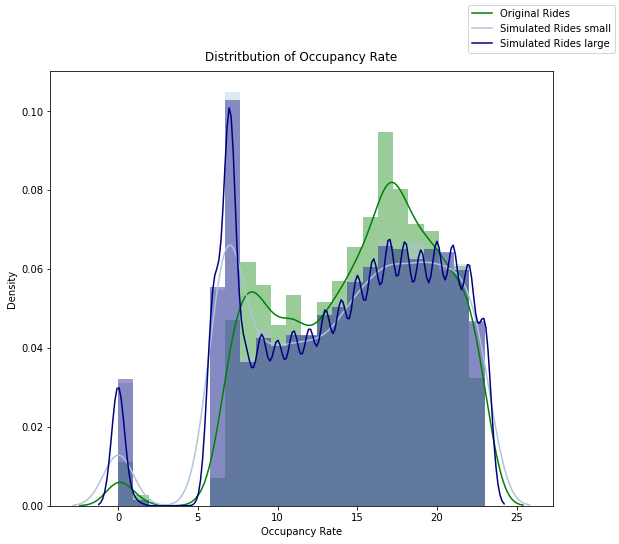

In [176]:
current_attribute = 'hour'
axlabel = 'Occupancy Rate'

fig = plt.figure(figsize=(9, 8))
sns.distplot(dist_df[current_attribute], color=color_rides, bins=24, hist_kws={'alpha': 0.4},axlabel=axlabel)
sns.distplot(dist_df_sim_s[current_attribute], color=color_rides_sim_s, bins=24, hist_kws={'alpha': 0.4},axlabel=axlabel)
sns.distplot(dist_df_sim_l[current_attribute], color=color_rides_sim_l, bins=24, hist_kws={'alpha': 0.4},axlabel=axlabel)

plt.title("Distritbution of Occupancy Rate", pad = 10)
fig.legend(labels=['Original Rides','Simulated Rides small','Simulated Rides large'])

plt.show()

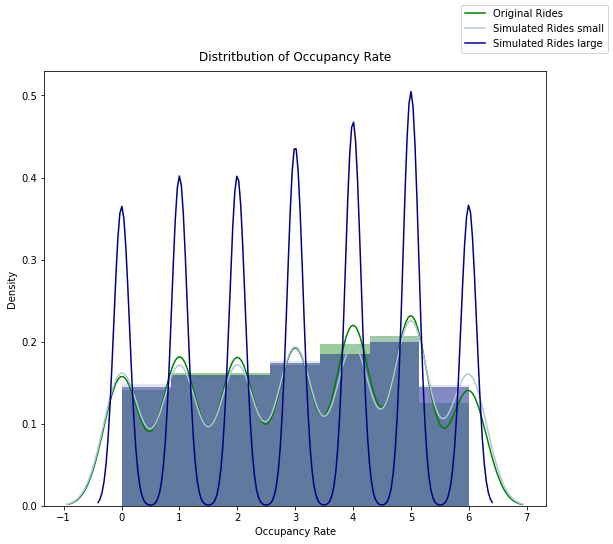

In [177]:
current_attribute = 'day_of_week'
axlabel = 'Occupancy Rate'

fig = plt.figure(figsize=(9, 8))
sns.distplot(dist_df[current_attribute], color=color_rides, bins=7, hist_kws={'alpha': 0.4},axlabel=axlabel)
sns.distplot(dist_df_sim_s[current_attribute], color=color_rides_sim_s, bins=7, hist_kws={'alpha': 0.4},axlabel=axlabel)
sns.distplot(dist_df_sim_l[current_attribute], color=color_rides_sim_l, bins=7, hist_kws={'alpha': 0.4},axlabel=axlabel)

plt.title("Distritbution of Occupancy Rate", pad = 10)
fig.legend(labels=['Original Rides','Simulated Rides small','Simulated Rides large'])

plt.show()

In [178]:
boxplot_df[["dataset","waiting_time"]]

,dataset,waiting_time
0,Original Rides,457.0
1,Original Rides,599.0
2,Original Rides,465.0
3,Original Rides,309.0
4,Original Rides,955.0
...,...,...
600001,Simulated Rides large,160.0
600002,Simulated Rides large,484.0
600003,Simulated Rides large,393.0
600004,Simulated Rides large,-94.0


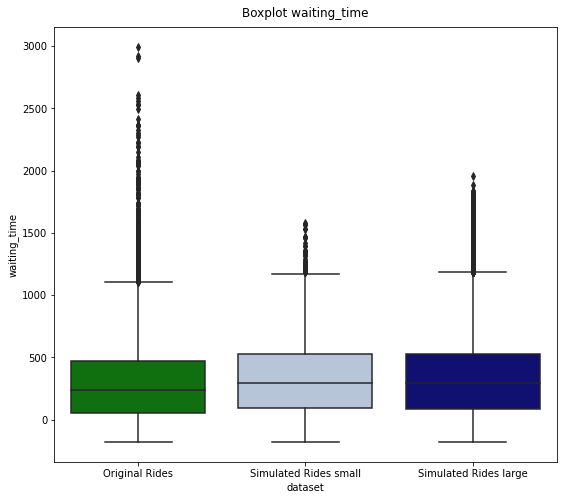

In [179]:
current_attribute = 'waiting_time'

fig = plt.figure(figsize=(9,8))
sns.boxplot(data=boxplot_df, x ="dataset",y=current_attribute,palette=[color_rides,color_rides_sim_s,color_rides_sim_l])

plt.title(f"Boxplot {current_attribute}", pad = 10)

plt.show()


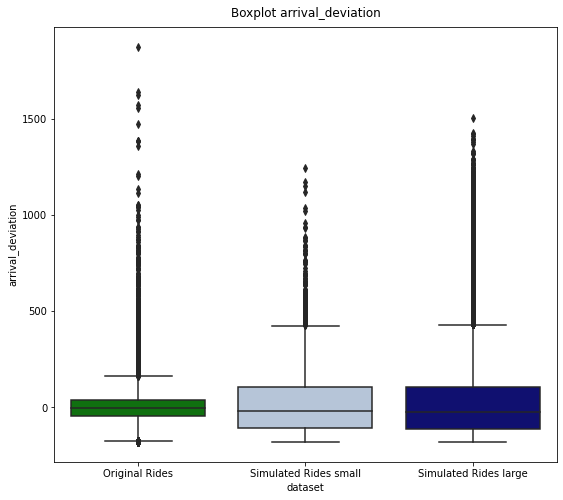

In [180]:
current_attribute = 'arrival_deviation'

fig = plt.figure(figsize=(9,8))
sns.boxplot(data=boxplot_df, x ="dataset",y=current_attribute,palette=[color_rides,color_rides_sim_s,color_rides_sim_l])

plt.title(f"Boxplot {current_attribute}", pad = 10)

plt.show()

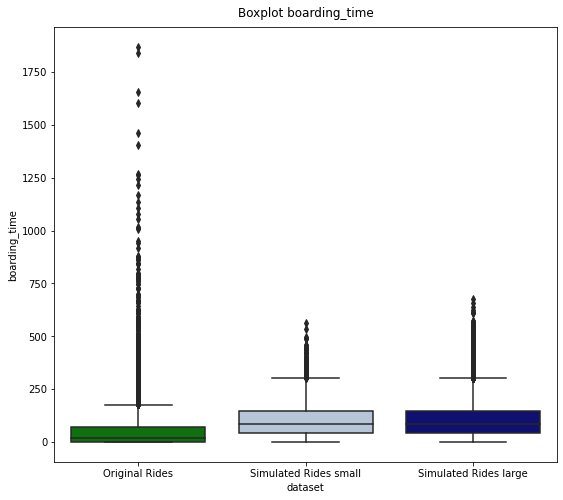

In [181]:
current_attribute = 'boarding_time'

fig = plt.figure(figsize=(9,8))
sns.boxplot(data=boxplot_df, x ="dataset",y=current_attribute,palette=[color_rides,color_rides_sim_s,color_rides_sim_l])

plt.title(f"Boxplot {current_attribute}", pad = 10)

plt.show()

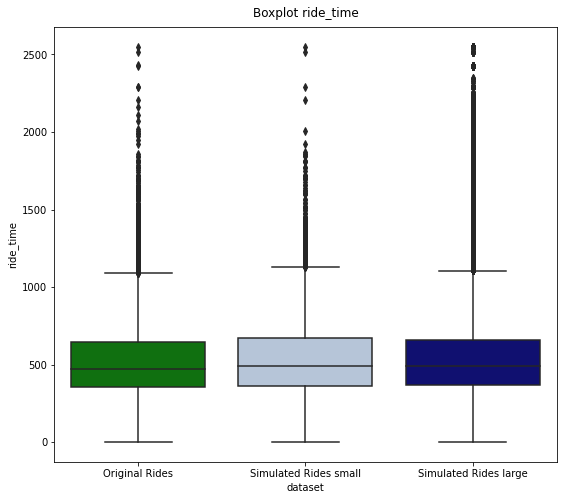

In [182]:
current_attribute = 'ride_time'

fig = plt.figure(figsize=(9,8))
sns.boxplot(data=boxplot_df, x ="dataset",y=current_attribute,palette=[color_rides,color_rides_sim_s,color_rides_sim_l])

plt.title(f"Boxplot {current_attribute}", pad = 10)

plt.show()

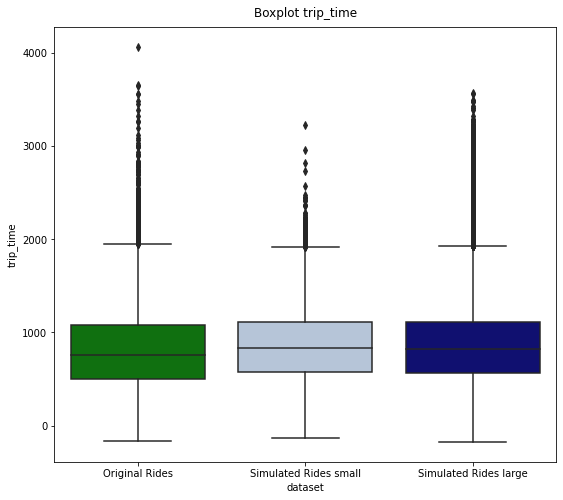

In [183]:
current_attribute = 'trip_time'

fig = plt.figure(figsize=(9,8))
sns.boxplot(data=boxplot_df, x ="dataset",y=current_attribute,palette=[color_rides,color_rides_sim_s,color_rides_sim_l])

plt.title(f"Boxplot {current_attribute}", pad = 10)

plt.show()

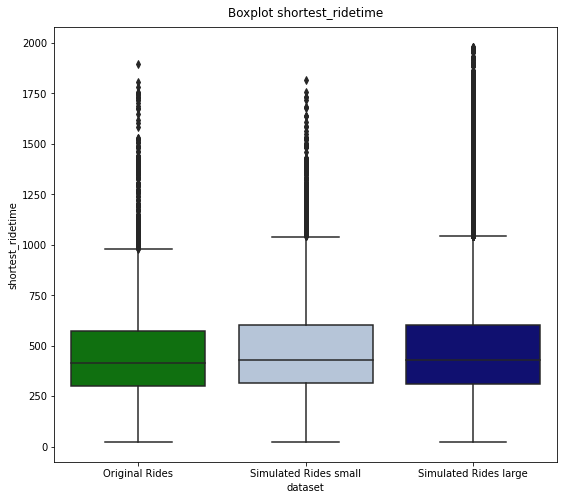

In [184]:
current_attribute = 'shortest_ridetime'

fig = plt.figure(figsize=(9,8))
sns.boxplot(data=boxplot_df, x ="dataset",y=current_attribute,palette=[color_rides,color_rides_sim_s,color_rides_sim_l])

plt.title(f"Boxplot {current_attribute}", pad = 10)

plt.show()


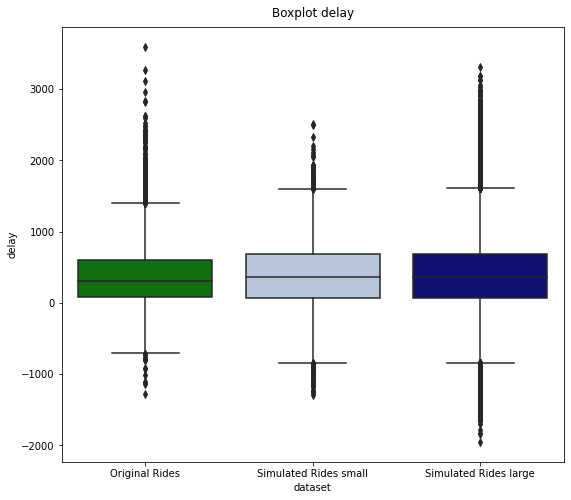

In [185]:
current_attribute = 'delay'

fig = plt.figure(figsize=(9,8))
sns.boxplot(data=boxplot_df, x ="dataset",y=current_attribute,palette=[color_rides,color_rides_sim_s,color_rides_sim_l])

plt.title(f"Boxplot {current_attribute}", pad = 10)

plt.show()

In [186]:
# df_value_counts = pd.DataFrame(dist_df["route"].value_counts().loc[lambda x : x>50])
input_df = dist_df.copy()

df_value_counts_rel = pd.DataFrame(input_df["route"].value_counts(normalize=True))
df_value_counts_abs = pd.DataFrame(input_df["route"].value_counts())
df_value_counts = pd.concat(objs= [df_value_counts_rel,df_value_counts_abs], axis=1)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['routes', 'rel_counts','abs_counts']
df_value_counts_rides = df_value_counts.copy()
df_value_counts_rides["dataset"] = "Original Rides"

df_value_counts_rides

,routes,rel_counts,abs_counts,dataset
0,100036004,0.020572,185,Original Rides
1,600410003,0.014900,134,Original Rides
2,10024007,0.010230,92,Original Rides
3,300210005,0.010008,90,Original Rides
4,40245010,0.007228,65,Original Rides
...,...,...,...,...
3325,70014020,0.000111,1,Original Rides
3326,130034039,0.000111,1,Original Rides
3327,100113003,0.000111,1,Original Rides
3328,100814001,0.000111,1,Original Rides


In [187]:
# df_value_counts = pd.DataFrame(dist_df["route"].value_counts().loc[lambda x : x>50])
input_df = dist_df_sim_s.copy()

df_value_counts_rel = pd.DataFrame(input_df["route"].value_counts(normalize=True))
df_value_counts_abs = pd.DataFrame(input_df["route"].value_counts())
df_value_counts = pd.concat(objs= [df_value_counts_rel,df_value_counts_abs], axis=1)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['routes', 'rel_counts','abs_counts']
df_value_counts_sim_s = df_value_counts.copy()
df_value_counts_sim_s["dataset"] = "Simulated Rides small"

df_value_counts_sim_s

,routes,rel_counts,abs_counts,dataset
0,100036004,0.017205,155,Simulated Rides small
1,10024007,0.012210,110,Simulated Rides small
2,600410003,0.010212,92,Simulated Rides small
3,300210005,0.009435,85,Simulated Rides small
4,40245010,0.008658,78,Simulated Rides small
...,...,...,...,...
3849,400116009,0.000111,1,Simulated Rides small
3850,901511011,0.000111,1,Simulated Rides small
3851,50051005,0.000111,1,Simulated Rides small
3852,402416009,0.000111,1,Simulated Rides small


In [188]:
# df_value_counts = pd.DataFrame(dist_df["route"].value_counts().loc[lambda x : x>50])
input_df = dist_df_sim_l.copy()

df_value_counts_rel = pd.DataFrame(input_df["route"].value_counts(normalize=True))
df_value_counts_abs = pd.DataFrame(input_df["route"].value_counts())
df_value_counts = pd.concat(objs= [df_value_counts_rel,df_value_counts_abs], axis=1)
df_value_counts = df_value_counts.reset_index()
df_value_counts.columns = ['routes', 'rel_counts','abs_counts']
df_value_counts_sim_l = df_value_counts.copy()
df_value_counts_sim_l["dataset"] = "Simulated Rides large"

df_value_counts_sim_l

,routes,rel_counts,abs_counts,dataset
0,100036004,0.017658,10595,Simulated Rides large
1,10024007,0.011248,6749,Simulated Rides large
2,600410003,0.010975,6585,Simulated Rides large
3,300210005,0.009495,5697,Simulated Rides large
4,40245010,0.006758,4055,Simulated Rides large
...,...,...,...,...
31323,40179004,0.000002,1,Simulated Rides large
31324,302011011,0.000002,1,Simulated Rides large
31325,40053013,0.000002,1,Simulated Rides large
31326,401512011,0.000002,1,Simulated Rides large


In [189]:
all_routes_df = pd.DataFrame(df_edges["start_id"].astype(str) + df_edges["end_id"].astype(str),columns=["routes"])
all_routes_df["abs_counts"] = 1
all_routes_df["rel_counts"] = all_routes_df["abs_counts"]/all_routes_df["abs_counts"].count()
all_routes_df


,routes,abs_counts,rel_counts
0,10011002,1,0.000025
1,10011003,1,0.000025
2,10011004,1,0.000025
3,10011005,1,0.000025
4,10011006,1,0.000025
...,...,...,...
40195,1800515014,1,0.000025
40196,1800515015,1,0.000025
40197,1800516009,1,0.000025
40198,1800516027,1,0.000025
